In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

## Load data

In [5]:
# load the data
dataframe = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
# convert to datetime
dataframe["date_added"] = pd.to_datetime(dataframe['date_added'])
dataframe['year'] = dataframe['date_added'].dt.year
dataframe['month'] = dataframe['date_added'].dt.month
dataframe['day'] = dataframe['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
dataframe['directors'] = dataframe['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
dataframe['categories'] = dataframe['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
dataframe['actors'] = dataframe['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
dataframe['countries'] = dataframe['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

dataframe.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,25.0,[Kirsten Johnson],[Documentaries],[],[United States]
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,[],"[International TV Shows, TV Dramas, TV Mysteries]","[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[South Africa]
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,9.0,24.0,[Julien Leclercq],"[Crime TV Shows, International TV Shows, TV Ac...","[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",[]
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,9.0,24.0,[],"[Docuseries, Reality TV]",[],[]
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,9.0,24.0,[],"[International TV Shows, Romantic TV Shows, TV...","[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...",[India]


In [6]:
print(dataframe.shape)

(8807, 19)


## Calculate TF-IDF matrix

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = dataframe['description']
vector = TfidfVectorizer(max_df=0.4,         
                             min_df=1,      
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,   
                             norm=u'l2',     
                             smooth_idf=True 
                            )
tfidf_matrix = vector.fit_transform(text_content) # <8807x18895 sparse matrix of type '<class 'numpy.float64'>'

    
request_transform = vector.transform(dataframe['description'])

In [9]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

## Load the graph 

In [12]:
graph = nx.Graph(label="MOVIE")
start_time = time.time()

for i, row in dataframe.iterrows():
    if (i % 1000 == 0):
        print(f"Row {i} -- {time.time() - start_time} seconds --")
    
    graph.add_node(row['title'], key=row['show_id'], label="MOVIE", media_type=row['type'], rating=row['rating'])
    
    for actor in row['actors']:
        graph.add_node(actor, label="PERSON")
        graph.add_edge(row['title'], actor, label="ACTED_IN")
    
    for category in row['categories']:
        graph.add_node(category, label="CAT")
        graph.add_edge(row['title'], category, label="CAT_IN")
    
    for director in row['directors']:
        graph.add_node(director, label="PERSON")
        graph.add_edge(row['title'], director, label="DIRECTED")
    
    for country in row['countries']:
        graph.add_node(country, label="COU")
        graph.add_edge(row['title'], country, label="COU_IN")
    
    indices = find_similar(tfidf_matrix, i, top_n=5)
    similar_node = f"Sim({row['title'][:15].strip()})"
    graph.add_node(similar_node, label="SIMILAR")
    graph.add_edge(row['title'], similar_node, label="SIMILARITY")
    
    for index in indices:
        graph.add_edge(similar_node, dataframe['title'].loc[index], label="SIMILARITY")

print(f"Finish -- {time.time() - start_time} seconds --")     

Row 0 -- 0.04040408134460449 seconds --
Row 1000 -- 5.773658275604248 seconds --
Row 2000 -- 11.524164915084839 seconds --
Row 3000 -- 17.332775354385376 seconds --
Row 4000 -- 23.174639463424683 seconds --
Row 5000 -- 28.866323709487915 seconds --
Row 6000 -- 34.6265435218811 seconds --
Row 7000 -- 40.4049551486969 seconds --
Row 8000 -- 46.18188714981079 seconds --
Finish -- 50.79066705703735 seconds --


## Draw a sub-graph of two movies

In [13]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in graph.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = graph.subgraph(sub_graph)
    colors=[]
    for i in subgraph.nodes():
        if graph.nodes[i]['label']=="MOVIE":
            colors.append('red')
        elif graph.nodes[i]['label']=="PERSON":
            colors.append('blue')
        elif graph.nodes[i]['label']=="CAT":
            colors.append('green')
        elif graph.nodes[i]['label']=="COU":
            colors.append('yellow')
        elif graph.nodes[i]['label']=="SIMILAR":
            colors.append('orange')    

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

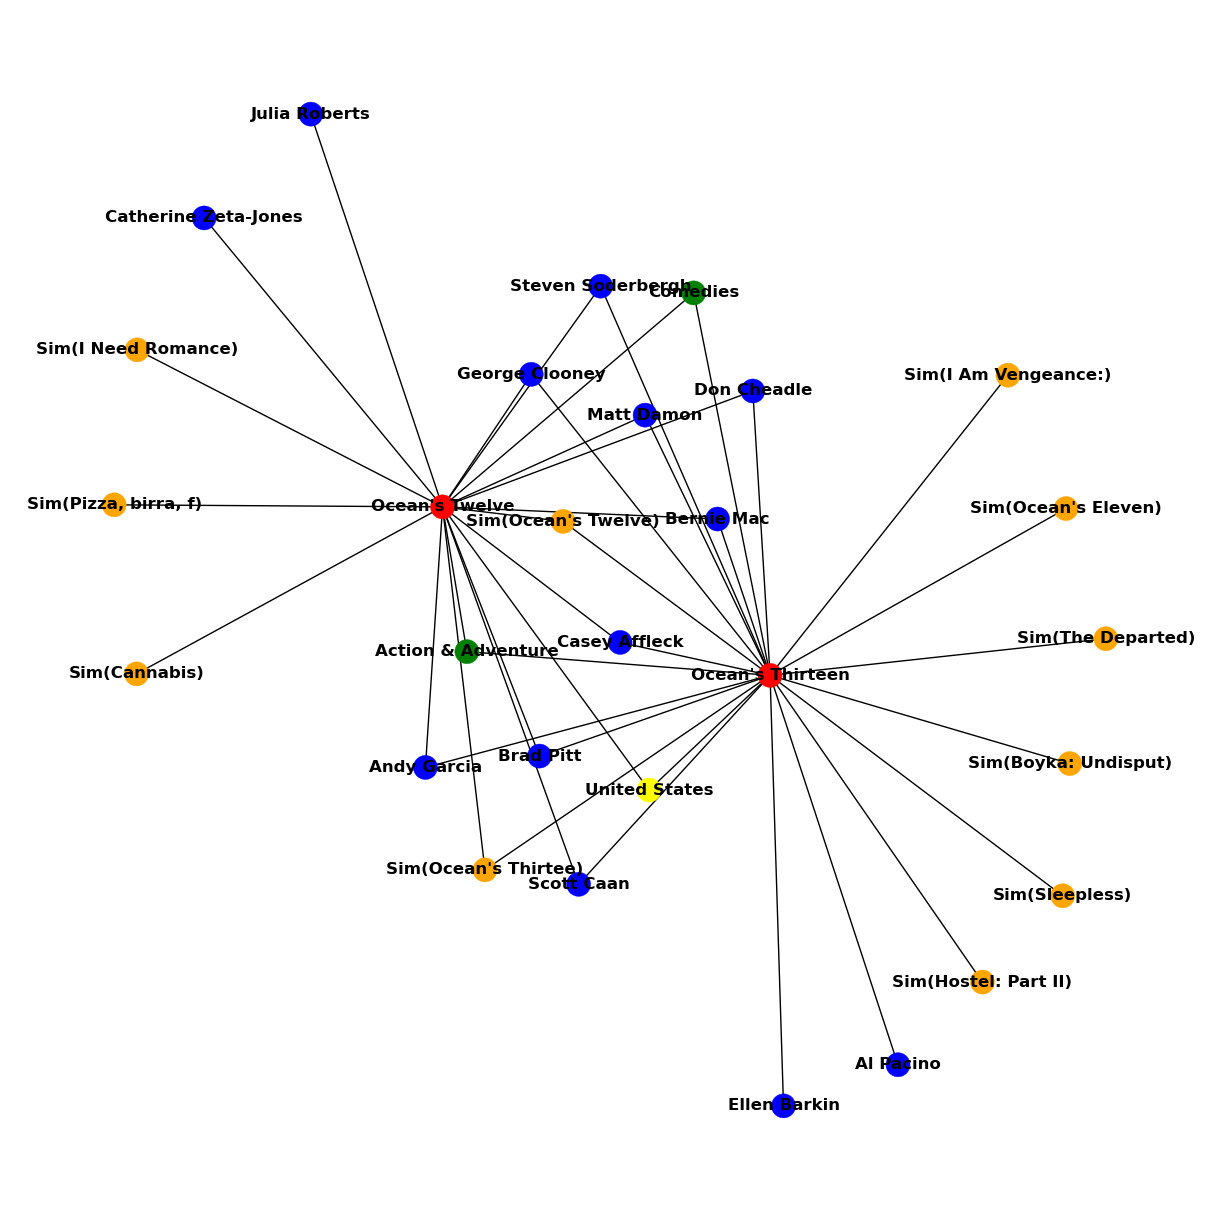

In [16]:
movies=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(movies)
draw_sub_graph(sub_graph)

## The recommendation system

In [19]:
def get_recommendation(root):
    commons_dict = {}
    for e1 in graph.neighbors(root):
        for e2 in graph.neighbors(e1):
            if e2==root:
                continue
            if graph.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e1]})
                else:
                    commons.append(e1)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(graph.degree(e1))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result

In [20]:

result1 = get_recommendation("Stranger Things")
result2 = get_recommendation("Squid Game")

print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result1.head())
print("*"*40+"\n Recommendation for 'Squid Game'\n"+"*"*40)
print(result2.head())

****************************************
 Recommendation for 'Stranger Things'
****************************************
Beyond Stranger Things            8.929770
Rowdy Rathore                     2.790553
Safe Haven                        2.790553
Chilling Adventures of Sabrina    2.232443
The Autopsy of Jane Doe           2.232443
dtype: float64
****************************************
 Recommendation for 'Squid Game'
****************************************
Chief of Staff      1.674332
Gonul               1.674332
Children of Adam    1.674332
Kakegurui           1.674332
Occupied            1.674332
dtype: float64


## Draw the graph

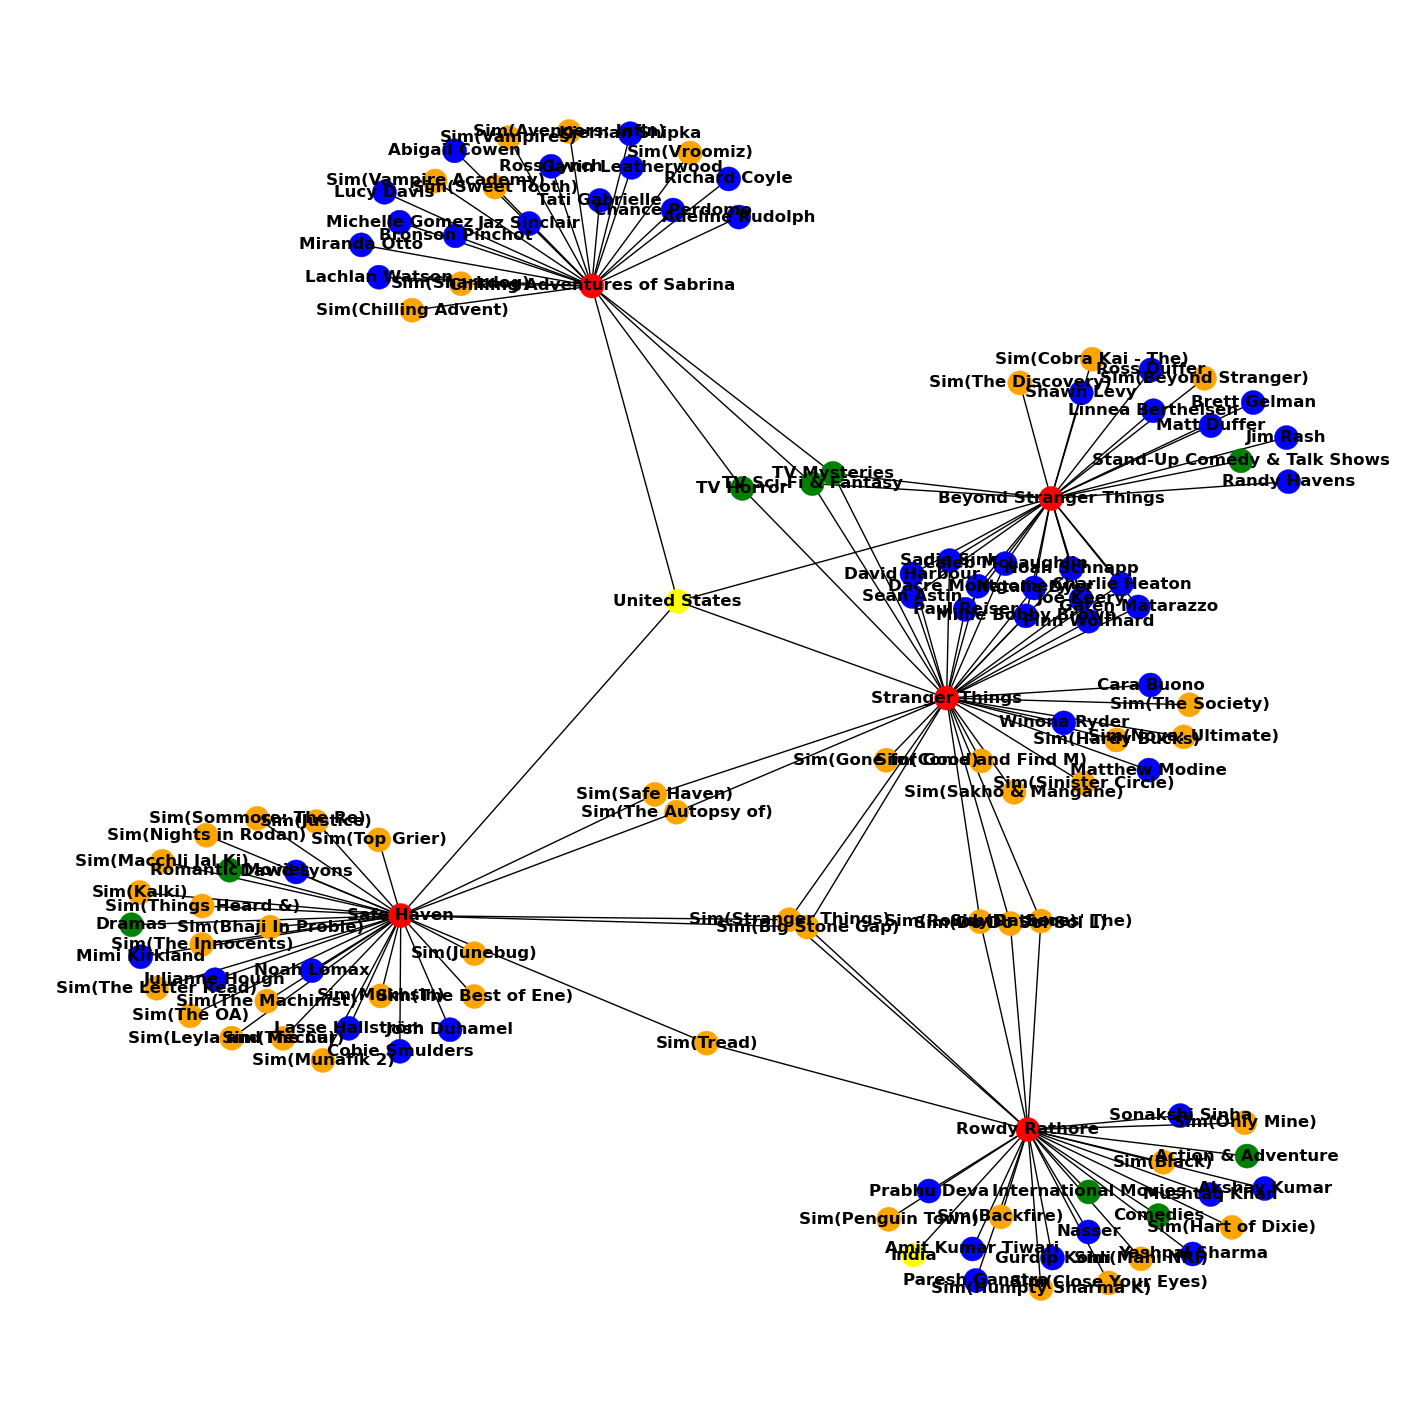

In [23]:
reco_movies=list(result1.index[:4].values)
reco_movies.extend(["Stranger Things"])
sub_graph = get_all_adj_nodes(reco_movies)
draw_sub_graph(sub_graph)

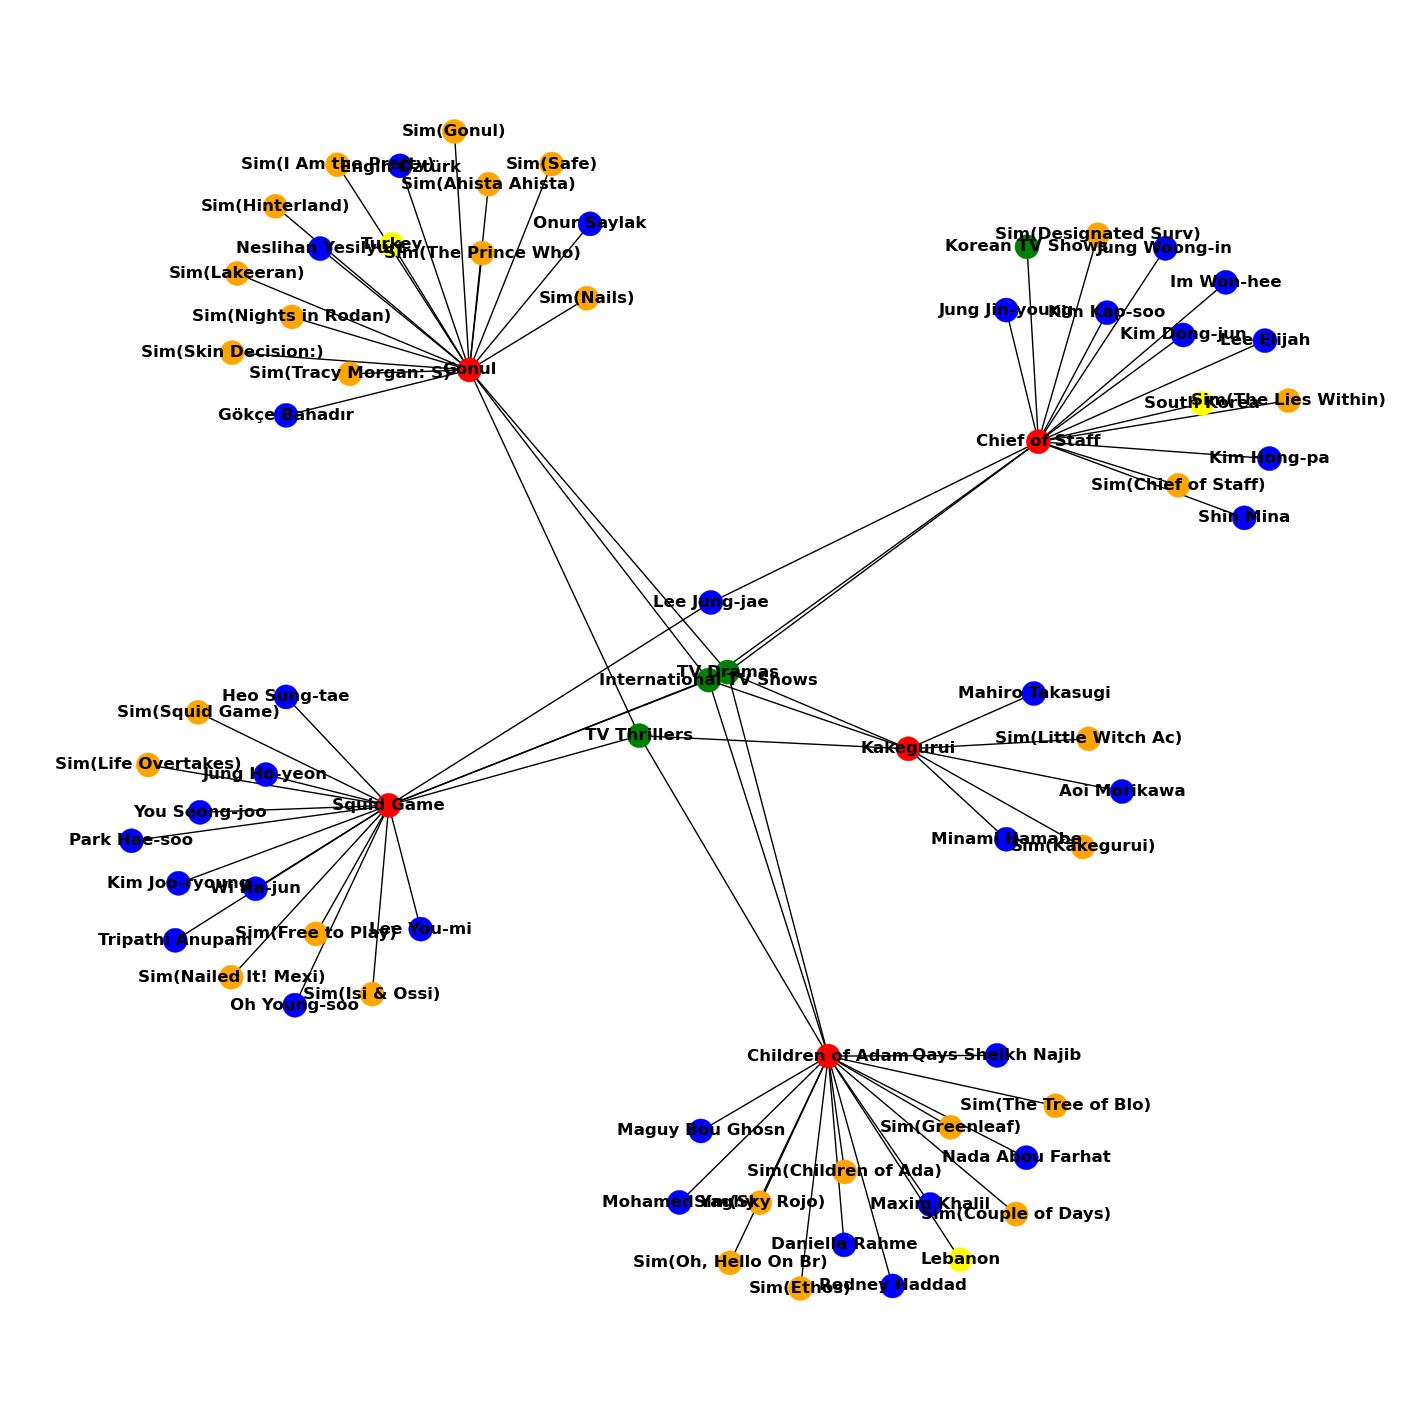

In [24]:
reco_movies=list(result2.index[:4].values)
reco_movies.extend(["Squid Game"])
sub_graph = get_all_adj_nodes(reco_movies)
draw_sub_graph(sub_graph)